# Foraging

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import time
from torch import nn
import torch

np.random.seed(42)

# 1 - Grid

## 1.1 - Grid

In [29]:
grid_shape = [7, 7]

grid = np.zeros(grid_shape).astype(int)
print(grid)

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


## 1.2 - Agents

In [30]:
n_agents = 1
agents = list(range(-n_agents,0))

# Getting all empty indexes from the grid: [[0,0], [0,1], ...]
empty_indexes = np.stack(np.where(grid == 0)).T

# Sampling 1 empty index from empty_indexes 
random_i = np.random.choice(range(empty_indexes.shape[0]), n_agents)
agent_idxs = empty_indexes[random_i,:]

# Adding prizes to grid with label 'reward_prize'
for i, idx in enumerate(agent_idxs):
    grid[idx[0], idx[1]] = agents[i]
    
print(grid)

[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0]
 [ 0  0  0  0  0  0  0]]


## 1.3 - Apple

In [31]:
# possible_values = list(range(1,n_agents+1))
possible_values = [1]
n_apples = 5

# Symbol for the prize in the grid
symbol_apple = 1

# Getting all empty indexes from the grid: [[0,0], [0,1], ...]
empty_indexes = np.stack(np.where(grid == 0)).T

# Sampling 1 empty index from empty_indexes 
random_i = np.random.choice(range(empty_indexes.shape[0]), n_apples)
prize_idxs = empty_indexes[random_i,:]

# Sampling foraging value
values = np.random.choice(possible_values, n_apples)

# Adding prizes to grid with label 'reward_prize'
for i, idx in enumerate(prize_idxs):
    grid[idx[0], idx[1]] = values[i]
    
print(grid)

[[ 0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0]
 [ 0  1  0  0  0  0  0]]


## 1.4 - Functions

#### 1.4.1 - Plotting game

In [32]:
# Function that plots the grid
def plot_game(grid):

    apple_locs = list(set(grid[grid>0]))
    agent_locs = list(set(grid[grid<0]))

    # Defining colors for each symbol
    colors = {0: 'lightgrey'}
    colors.update({loc:'red' for loc in apple_locs})
    colors.update({loc:'cyan' for loc in agent_locs})

    clear_output(wait=True)

    # Convert the matrix values to a list of colors
    unique_values = list(colors.keys())  # Extract unique values in the correct order
    
    color_list = [colors[val] for val in unique_values]  # Generate a list of colors in the order of unique values
    # Create a ListedColormap using the colors
    cmap = ListedColormap(color_list)
    
    # Create an index map to translate values in the matrix to their corresponding indices in the cmap
    index_map = np.vectorize(lambda x: unique_values.index(x))(grid)

    fig, ax = plt.subplots(1, figsize=(5,5))
    
    # Plot the matrix using imshow and the custom colormap
    ax.imshow(index_map, cmap=cmap)

    for (j,i),label in np.ndenumerate(grid):
        if label > 0:
            ax.text(i,j,label,ha='center',va='center', fontsize=14)
        elif label < 0:
            ax.text(i,j,r'$x_{}$'.format(label*-1), ha='center',va='center', fontsize=14)
    plt.axis('off')

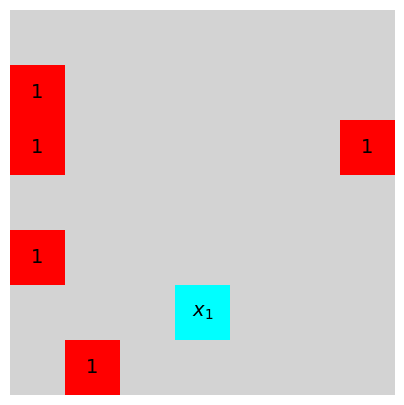

In [33]:
plot_game(grid)

In [34]:
grid_init = np.copy(grid)
def reset():
    return np.copy(grid_init)

#### 1.4.2 - Dynamics 

In [35]:
# Getting the agent's [x,y] coordinates
def get_agent_pos(grid, agent):
    return np.hstack(np.where(grid == agent))

In [36]:
def rand_init(grid):

    pos = np.where(grid<0)
    for i in range(len(pos[0])):
        grid[pos[0][i], pos[1][i]] = 0
    
    # Getting all empty indexes from the grid: [[0,0], [0,1], ...]
    empty_indexes = np.stack(np.where(grid == 0)).T
    
    # Sampling 1 empty index from empty_indexes 
    random_i = np.random.choice(range(empty_indexes.shape[0]), n_agents)
    agent_idxs = empty_indexes[random_i,:]
    
    # Adding prizes to grid with label 'reward_prize'
    for i, idx in enumerate(agent_idxs):
        grid[idx[0], idx[1]] = agents[i]

In [37]:
# Allowed movements
MOVEMENTS = {
    'left': np.array([0,-1]), 
    'down':np.array([1,0]), 
    'right':np.array([0,1]), 
    'up':np.array([-1,0])
}

ACTIONS = list(MOVEMENTS.keys()) + ['collect', 'rest']
ACTIONS

['left', 'down', 'right', 'up', 'collect', 'rest']

In [38]:
# Reward for each time step
reward_timestep = -0.1

In [39]:
NEIGH = [[i,j] for i in [-1,0,1] for j in [-1,0,1]]
NEIGH

[[-1, -1], [-1, 0], [-1, 1], [0, -1], [0, 0], [0, 1], [1, -1], [1, 0], [1, 1]]

In [40]:
def act(action, agent, grid):
    
    # We copy the grid so that our changes dont reflect on the grid
    grid = grid.copy()

    terminate = False

    reward = reward_timestep
    
    # If the action is not allowed (e.g. 'banana'), we raise an error
    if action not in ACTIONS:
        raise ValueError(f'Possible actions are: { ACTIONS }')
    
    # Otherwise, perform movement
    elif action in MOVEMENTS.keys():
        
        # Getting current position of the agent
        curr_pos = get_agent_pos(grid, agent)
        
        # Getting the next position. 
        # Note that if the action would take the agent outside the grid, the agent stays in place.
        next_pos = curr_pos + MOVEMENTS[action]
        next_pos[0] = np.clip(next_pos[0], 0, grid_shape[0]-1)
        next_pos[1] = np.clip(next_pos[1], 0, grid_shape[1]-1)

        if grid[next_pos[0], next_pos[1]] == 0:
            grid[curr_pos[0], curr_pos[1]] = 0
            grid[next_pos[0], next_pos[1]] = agent   
            
    elif action == 'rest':
        pass
        
    elif action == 'collect':

        # Getting current position of the agent
        curr_pos = get_agent_pos(grid, agent)

        for value in sorted(possible_values, reverse=True):
            
            for delta in NEIGH:

                # Getting neighbordhoods
                x = np.clip(curr_pos[0] + delta[0], 0, grid.shape[0]-1)
                y = np.clip(curr_pos[1] + delta[1], 0, grid.shape[1]-1)
                
                if grid[x, y] == value:
                    neigh_agents = []
                    
                    for delta_app in NEIGH:
                        
                        # Getting neighbordhoods
                        x2 = np.clip(x + delta_app[0], 0, grid.shape[0]-1)
                        y2 = np.clip(y + delta_app[1], 0, grid.shape[1]-1)
                        
                        if grid[x2, y2] < 0:
                            neigh_agents.append(grid[x2, y2])
                            
                    neigh_agents = set(neigh_agents)
                    
                    if len(neigh_agents) >= value:
                        reward += 1
                        grid[x,y] = 0
                        break
    if len(grid[grid>0])==0:
        terminate = True
    return (grid, reward, terminate)

In [41]:
def play(policy, n_epis=10, T=100, show_games=False, plot_value=False, rand_init=False):
    
    V = {agent:[] for agent in agents}

    for _ in tqdm(range(n_epis)):
        grid = reset()
        V_epi = {agent:0 for agent in agents}
        for i in range(T):
            actions = policy(grid)
            for j, agent in enumerate((agents)):
                action = actions[j]
                grid,r,terminate = act(action, agent, grid)
                V_epi[agent] += r
                if show_games:
                    time.sleep(0.001)
                    plot_game(grid)
                    plt.title(' || '.join([f'$x_{-agent}$: {round(V_epi[agent],2)}' for agent in sorted(agents, reverse=True)]))
                    plt.show()
                    
                if terminate:
                    return V
        for agent in agents:
            V[agent].append(V_epi[agent])

    if plot_value:
        for agent in agents:
            plt.plot(V[agent], label=f'$x_{-agent}$')
        plt.legend()
        plt.show()
    return V

# 2 - Single Agent Learning

### 2.1 - REINFORCE

In [42]:
# Class Definition
class PolNet(nn.Module):
    def __init__(self, grid_size, n_actions):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(start_dim=0, end_dim=-1),
            nn.Linear(grid_size, n_actions),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, grid):
        grid = torch.tensor([grid], dtype=torch.float)
        return self.model(grid)

In [43]:
# Policy
def policy_REINFORCE(grid):
    actions = []
    for i, agent in enumerate(agents):
        action_probs = PolNets[i](grid).detach().numpy()
        action_idx = np.random.choice(range(len(ACTIONS)), p=action_probs)
        actions.append(ACTIONS[action_idx])
    return actions

**Training**

In [44]:
def generate_trajectory(PolNets, n_max=1000):
    
    grid = reset()
    trajectory = [{"s":[], "a":[], "probs": [], "s'":[], "r":[]} for _ in range(n_agents)] # (state, action, state', reward)
    
    for _ in range(n_max):
        for i, agent in enumerate(agents):
                
            # Current State
            curr_state = grid
            
            # Sample Action using Policy Network
            action_probs = PolNets[i](grid)
            action_idx = np.random.choice(range(len(ACTIONS)), p=action_probs.detach().numpy())
            action = ACTIONS[action_idx]
            
            # Transition + Reward
            (next_grid, reward, terminate) = act(action, agent, grid)
            next_state = next_grid
            
            # Save
            trajectory[i]["s"].append(curr_state)
            trajectory[i]["a"].append(action_idx)
            trajectory[i]["probs"].append(action_probs)
            trajectory[i]["s'"].append(next_state)
            trajectory[i]["r"].append(reward)
            
            # Update Actual State
            grid = next_grid
            
            if terminate:
                return trajectory
                
    return trajectory

In [45]:
PolNets = [PolNet(np.size(grid), len(ACTIONS)) for i in range(n_agents)]
optims = [torch.optim.Adam(PolNet.parameters(), lr=0.01) for PolNet in PolNets]

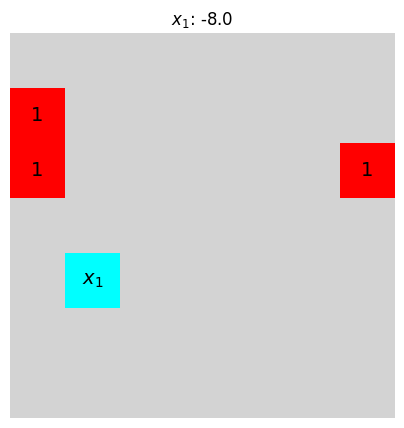

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/it]


In [46]:
V = play(policy_REINFORCE, n_epis=1, T=100, show_games=True)

100%|█████████████████████████████████████████| 700/700 [00:12<00:00, 57.57it/s]


Text(0, 0.5, 'Return')

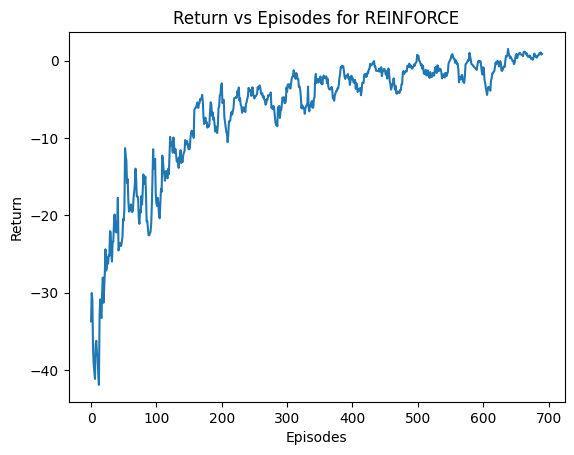

In [47]:
n_episodes = 700
gamma = 0.95

V = []

for _ in tqdm(range(n_episodes)):

    trajectory = generate_trajectory(PolNets)

    for i, agent in enumerate(agents):
        
        Returns = []
        for j, s in enumerate(trajectory[i]["s"]):
            G = 0
            for k, r in enumerate(trajectory[i]["r"][j:]):
                G += (gamma**k)*r
            Returns.append(G)
            
        loss = 0
        for j, (s, a_idx, probs, ret) in enumerate(zip(trajectory[i]["s"], trajectory[i]["a"], trajectory[i]["probs"], Returns)):
            
            dist = torch.distributions.Categorical(probs=probs)    
            log_prob = dist.log_prob(torch.tensor(a_idx))
            
            loss += -log_prob*ret
            
        optims[i].zero_grad()
        loss.backward()
        optims[i].step()
            
    V.append(sum(trajectory[0]["r"]))

plt.title('Return vs Episodes for REINFORCE')
plt.plot(np.convolve(V, np.ones(10)/10, mode='valid'))
plt.xlabel('Episodes')
plt.ylabel('Return')

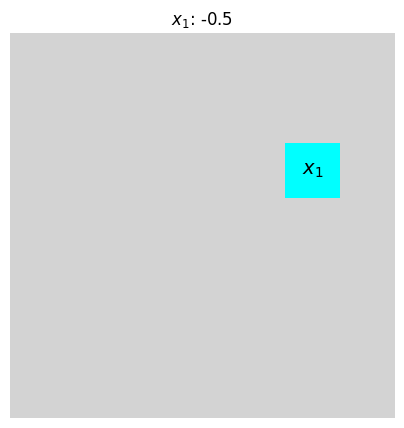

  0%|                                                     | 0/1 [00:01<?, ?it/s]


In [49]:
V = play(policy_REINFORCE, n_epis=1, T=100, show_games=True)

### 2.2 - Neural Fitted Q

In [210]:
class NFQ(nn.Module):
    def __init__(self, grid_size, n_actions):
        super().__init__()
        self.fc = nn.Linear(10, n_actions)
        self.model = nn.Sequential( nn.Flatten(start_dim=0, end_dim=-1),
                                    nn.Linear(grid_size, n_actions)
                                  )
        
    def forward(self, grid):
        grid = torch.tensor([grid], dtype=torch.float)
        return self.model(grid)


### Training

100%|█████████████████████████████████████████| 500/500 [00:18<00:00, 27.69it/s]


Text(0, 0.5, 'Return')

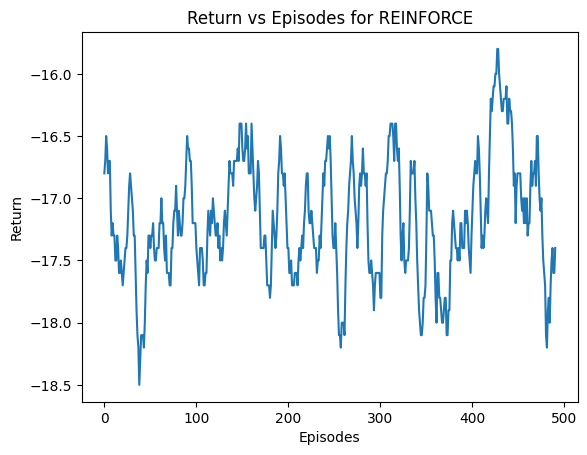

In [211]:
Qs = [NFQ(np.size(grid), len(ACTIONS)) for i in range(n_agents)]
optims = [torch.optim.Adam(Q.parameters(), lr=1e-1) for Q in Qs]
losses = torch.nn.HuberLoss()

n_steps_per_episodes = 200
n_episodes = 500
eps = 0.5
gamma = 0.99
V = []

for _ in tqdm(range(n_episodes)):
    grid = reset()
    epi_reward = 0
    
    for _ in range(n_steps_per_episodes):
        
        for i, agent in enumerate(agents):
            
            optims[i].zero_grad()
            
            with torch.no_grad():
                if np.random.rand() < eps:
                    action = np.random.choice(ACTIONS)
                    idx = ACTIONS.index(action)
                else:
                    idx = Qs[i](grid).argmax()
                    action = ACTIONS[idx]
                    
            (next_grid, reward, terminate) = act(action, agent, grid)

            curr_value = Qs[i](grid)[idx]
            with torch.no_grad():
                boot_value = (reward + gamma*Qs[i](next_grid).max())

            loss = losses(curr_value, boot_value)
            loss.backward()

            optims[i].step()

            grid = next_grid

            epi_reward += reward

            if terminate:
                break
                
    V.append(epi_reward)

plt.title('Return vs Episodes for REINFORCE')
plt.plot(np.convolve(V, np.ones(10)/10, mode='valid'))
plt.xlabel('Episodes')
plt.ylabel('Return')

### Test

In [212]:
def policy_NFQ(grid):
    actions = [ACTIONS[Qs[i](grid).argmax()] for i, agent in enumerate(agents)]
    print(actions)
    return actions

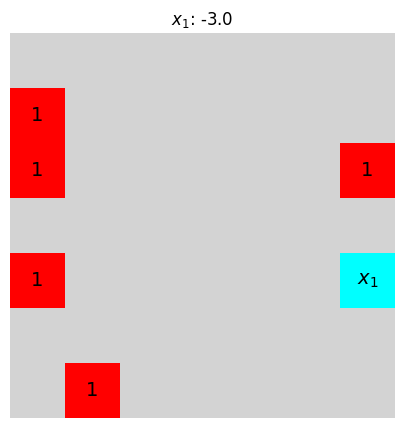

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


In [213]:
V = play(policy_NFQ, n_epis=1, T=30, show_games=True)